# Trained Models VGG19, ResNet50, ConvNext



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nirmalsankalana/crop-pest-and-disease-detection

100% 1.24G/1.25G [00:15<00:00, 128MB/s] 
100% 1.25G/1.25G [00:15<00:00, 85.5MB/s]


In [ ]:
# !unzip /content/crop-pest-and-disease-detection.zip -d /content/dataset/

In [ ]:
# import zipfile
# zip=zipfile.ZipFile("/content/crop-pest-and-disease-detection.zip",'r')
# zip.extractall()
# zip.close()

In [ ]:
import os
import zipfile

# Create the folder where you want to unzip the file
folder_name = '/content/dataset'
os.makedirs(folder_name, exist_ok=True)

# Unzip the file into the created folder
zip_file = '/content/crop-pest-and-disease-detection.zip'
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(folder_name)


# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.convnext import ConvNeXtBase


from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

# Preparing Dataset


In [ ]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             width_shift_range=0.2,
                             validation_split=0.2,
                             )

In [ ]:
import os
from PIL import Image
import numpy as np
import shutil

data_dir=r'/content/dataset'
bad_img_list=[]
total=0
good=0
bad=0
classes=sorted(os.listdir(data_dir))
for klass in classes:
    good_class=0
    bad_class=0
    total_class=0
    msg=f'processing class {klass}'
    print(msg, '\r', end= '')
    classpath=os.path.join(data_dir, klass)
    flist=sorted(os.listdir(classpath))
    for f in flist:
        total +=1
        total_class +=1
        fpath=os.path.join(classpath,f)
        try:
            img= Image.open(fpath)
            array=np.asarray(img)
            good +=1
            good_class +=1
        except:
            bad_img_list.append(fpath)
            bad +=1
            bad_class +=1

    msg=f'class {klass} contains {total_class} files, {good_class} are valid image files and {bad_class} defective image files'
    print (msg)
msg=f'the dataset contains {total} image files, {good} are valid image files and {bad} are defective image files'
print (msg)
if bad>0:
    ans=input('to print a list of defective image files enter P, to not print press Enter')
    if ans == 'P' or ans == 'p':
        for f in bad_img_list:
            print (f)

class Cashew anthracnose contains 1729 files, 1729 are valid image files and 0 defective image files
class Cashew gumosis contains 392 files, 392 are valid image files and 0 defective image files
class Cashew healthy contains 1368 files, 1368 are valid image files and 0 defective image files
class Cashew leaf miner contains 1378 files, 1378 are valid image files and 0 defective image files
class Cashew red rust contains 1682 files, 1682 are valid image files and 0 defective image files
class Cassava bacterial blight contains 2614 files, 2614 are valid image files and 0 defective image files
class Cassava brown spot contains 1481 files, 1481 are valid image files and 0 defective image files
class Cassava green mite contains 1015 files, 1015 are valid image files and 0 defective image files
class Cassava healthy contains 1193 files, 1193 are valid image files and 0 defective image files
class Cassava mosaic contains 1205 files, 1205 are valid image files and 0 defective image files
class

In [ ]:
# this code creates a corrected dataset with the defective image files removed
# you can use this dataset to create a model.
working_dir=r'/content/working_dataset'
corrected_dir=os.path.join(working_dir, 'corrected_dataset') # where the corrected dataset will be stored
copied_count = 0
if os.path.isdir(corrected_dir):
    shutil.rmtree(corrected_dir) # make sure the corrected_dir is empty
os.mkdir(corrected_dir)
for klass in classes:
    classpath=os.path.join(data_dir, klass)
    dest_classpath=os.path.join(corrected_dir, klass)
    os.mkdir(dest_classpath)
    flist= os.listdir(classpath)
    for f in flist:
        fpath=os.path.join(classpath,f)
        dest_fpath=os.path.join(dest_classpath,f)
        if fpath not in bad_img_list:
            shutil.copy(fpath, dest_fpath)
            copied_count +=1
msg=f'{copied_count} valid image files were stored in {corrected_dir}'
print(msg)

25126 valid image files were stored in /content/working_dataset/corrected_dataset


In [ ]:
batch_size = 16

training_generator = datagen.flow_from_directory(
    corrected_dir,
    target_size=(224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training',
)

validation_generator = datagen.flow_from_directory(
    corrected_dir,
    target_size=(224, 224),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation',
)

Found 20110 images belonging to 22 classes.
Found 5016 images belonging to 22 classes.


In [ ]:
def cnn_model(base_model):
    for layer in base_model.layers:
        layer.trainable = False

    # Classifier
    num_classes = 22
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(units=1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(units=512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    pred = layers.Dense(units=num_classes, activation='softmax')(x)

    # Model
    model = models.Model(inputs=base_model.input, outputs=pred)

    # Compilation
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Create instances of the pre-trained models and compile them
# vgg19_model = cnn_model(VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3)))
# resnet50_model = cnn_model(ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3)))
convnext_base_model = cnn_model(ConvNeXtBase(include_top=False, weights='imagenet', input_shape=(224,224,3)))

350926856/350926856 [==============================] - 5s 0us/step


In [ ]:
models_dict = {
    # 'VGG19': vgg19_model,
    # 'ResNet50': resnet50_model,
    'ConvNextBase': convnext_base_model,
}

Training ConvNextBase
Epoch 1/10
1257/1257 [==============================] - 570s 434ms/step - loss: 1.0128 - accuracy: 0.6503 - val_loss: 0.8431 - val_accuracy: 0.6774 - lr: 0.0010
Epoch 2/10
1257/1257 [==============================] - 529s 421ms/step - loss: 0.7134 - accuracy: 0.7457 - val_loss: 0.9712 - val_accuracy: 0.6404 - lr: 0.0010
Epoch 3/10
1257/1257 [==============================] - 527s 419ms/step - loss: 0.6460 - accuracy: 0.7695 - val_loss: 0.8685 - val_accuracy: 0.6732 - lr: 0.0010
Epoch 4/10
1257/1257 [==============================] - 526s 418ms/step - loss: 0.6230 - accuracy: 0.7789 - val_loss: 0.8720 - val_accuracy: 0.6850 - lr: 0.0010
Epoch 5/10
1257/1257 [==============================] - 526s 418ms/step - loss: 0.6020 - accuracy: 0.7876 - val_loss: 0.8375 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 6/10
1257/1257 [==============================] - 524s 417ms/step - loss: 0.5834 - accuracy: 0.7944 - val_loss: 0.8177 - val_accuracy: 0.6982 - lr: 0.0010
Epoch 7/10
1

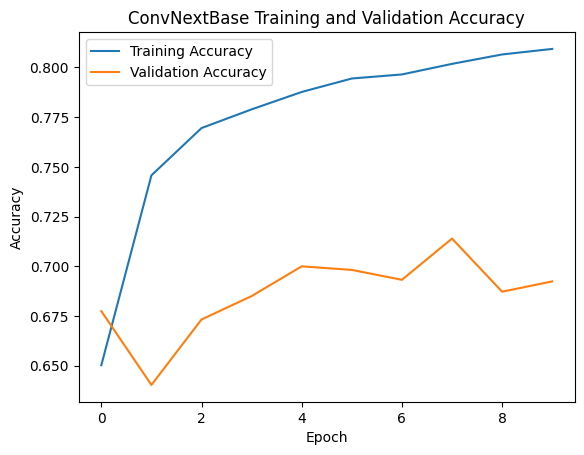

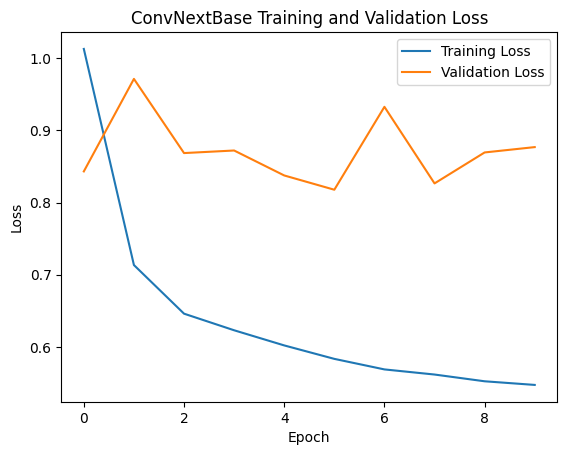

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
epochs = 10
for model_name, model in models_dict.items():
  print(f"Training {model_name}")
  callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-10),
             EarlyStopping(monitor='val_loss', patience=15)]
  history = model.fit(
      training_generator,
      epochs=epochs,
      validation_data=validation_generator,
      callbacks=callbacks,
    )

  # Plotting the training history
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title(f'{model_name} Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()


  # Plotting the loss history
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(f'{model_name} Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  model.save(f'/content/drive/MyDrive/Corvit_AI/crop_disease/models/{model_name}.h5')
